In [1]:
#py_data_analysis env
import os
import process_observed_discharge as mQ
import glob
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import warnings
warnings.simplefilter("ignore")

#segoe UI font
plt.rcParams['font.family'] = 'Segoe UI'

### Unzip files and copy to common folder
First unzip the files in individual folders and then transfer the tmeseries files into a common folder. For this, use the uzip_files and copy_to_common_folder  functions in the process_observed_discharge module

In [2]:
src_zipped_wallonie = 'D:/VUB/_data/hydrometrie_wallonie/rawfiles'
common_folder_wallonie = 'D:/VUB/_data/hydrometrie_wallonie/unzipped_all'

src_zipped_waterinfo = 'D:/VUB/_data/waterinfo/zipped'
common_folder_waterinfo = 'D:/VUB/_data/waterinfo/unzipped'

#For stations in Flanders, the station metadata is downloaded from the Waterinfo website using the py_waterinfo package.
#I decided to download the timeseries one by one because I struggled with the py_waterinfo package. It also helped me to skip data from canals
#The data has been processed using the download_waterinfo_data.ipynb notebook and saved as a csv file (waterinfo_Q_Stations.csv).
#The csv file contains the station name and coordinates.
#Since we do not need to use Q data from canals, we filter out the stations that are not rivers.

#### Unzip the files (both Wallonie and Waterinfo)

In [3]:
#mQ.unzip_files(src_zipped_waterinfo, common_folder_waterinfo)

#copy files to common folder
#mQ.copy_to_common_folder(src_zipped, common_folder)

#### Extract station timeseries and coordinates for Wallonie data

From the list of downloaded and unzipped files, process the files to obtain station names and coordinates and properly formatted timeseries

In [4]:
#This part of the code takes a while to run, so we wrap it inside pickle function
#Q_dict, station_coords = mQ.extract_timeseries_wallonie(common_folder_wallonie)
Q_dict, station_coords = mQ.load_or_extract_wallonie_data(
    'Q_dict_wallonie.pickle',
    'station_coords_wallonie.pickle',
    mQ.extract_timeseries_wallonie,
    common_folder_wallonie
)

#### Intersect waterinfo timeseries with station metadata
Since we do not need to use Q data from canals, we filter out the stations that are not rivers, so that we only have 'natural' flows

In [5]:
src_waterinfo = 'D:/VUB/_data/waterinfo/unzipped'
waterinfo_timeseries = glob.glob(os.path.join(src_waterinfo, '*.csv'))
waterinfo_station_metadata = pd.read_csv('waterinfo_Q_Stations.csv')

waterinfo_natural_stations = []
waterinfo_natural_Q = {}

#check if folder exists
if not os.path.exists(src_waterinfo):
    print(f"Folder {src_waterinfo} does not exist")
    exit()
else:
    print(f"Processing files in {src_waterinfo}")

for file in waterinfo_timeseries:
    df  = pd.read_csv(file, sep=';', header=None, skiprows=8)
    #select only the columns we need
    df = df.iloc[:, [0, 1]]
    df.columns = ['Date', 'Q']

    #Date to datetime 2005-07-18T01:00:00.000+02:00
    df['Date'] = df['Date'].str[:10] #Extract the date part and remove the time part
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


    #set date as index
    df.set_index('Date', inplace=True)
    df.dropna(inplace=True) #drop rows with NaN values
    df.sort_index(inplace=True)

    #replace ',' with '.' in Q column ans convert to float
    df['Q'] = df['Q'].str.replace(',', '.').astype(float)

    #extract the station name from the file name and remove the _Discharge part
    raw_name = os.path.basename(file).split('.')[0]
    station_name = re.sub(r'_Discharge$|_+$', '', raw_name) # Remove any trailing underscores

    waterinfo_natural_stations.append(station_name)
    waterinfo_natural_Q[station_name] = df

#filter the waterinfo_station_metadata dataframe to only include the stations that are in the waterinfo_natural_stations list
waterinfo_natural_metadata = waterinfo_station_metadata[waterinfo_station_metadata['station_name'].isin(waterinfo_natural_stations)]

Processing files in D:/VUB/_data/waterinfo/unzipped


In [6]:
missing = set(waterinfo_natural_stations) - set(waterinfo_station_metadata['station_name'])
len(missing)

#This means there are some stations which have data but their coordinates are not in the metadata file.
#We will only use the stations that are in the metadata file, whose coordinates are known.

11

In [7]:
missing

{'Dendermonde afw Dender calc_Zeeschelde',
 'Gent IN calc_LeieBovenschelde',
 'Grens België-Nederland calc_Zeeschelde',
 'Heffen Monding calc_Zenne',
 'Liege Afwaarts Onverdeeld calc_Meuse',
 'Schelle calc_Zeeschelde',
 'Tielrode Monding calc_Durme',
 'Walem Monding calc_Dijle',
 'Wintam Monding calc_Rupel',
 'Wintam opw Rupel calc_Zeeschelde',
 'Zelzate Grens B-NL calc_Kl Gent-Terneuzen'}

#### Join Waterinfo and Wallonie station metadata
This will be used to extract the simulated flow from mHM.

To reduce runtime, we will only medium-sized stations with minimum peak flows of say 20m ${^3}/s$ and at least ten years of data

In [8]:
threshold_max = 10 #this is the maximum Q in the timeseries, can be adjusted
min_length_days = 365 #this is the minimum number of days with valid data, can be adjusted

#Get the dictionary of evaluation timeseries df
eval_stations_wallonie = mQ.extract_eval_stations(Q_dict, threshold_max, min_length_days)
eval_stations_waterinfo = mQ.extract_eval_stations(waterinfo_natural_Q, threshold_max, min_length_days)

In [9]:
len(list(eval_stations_waterinfo.keys()))

78

### Extract subset of station for evaluating the model
Here we extract the station coordinates to be used for evaluating model performance
We also correct the coordinates of some stations so they intersect with streams in mHM. The correction of the coordinates is based on visual inspection of overlaying the stations and the mRM netCDF grid on QGIS. 

In [10]:
corrected_coordinates = pd.read_csv('subset_of_eval_stations_corrected_coordinates.csv')

#Extract the coordinates of the evaluation stations from the station_coords dataframe
eval_stations_wallonie_coords = station_coords[station_coords['station_name'].isin(eval_stations_wallonie)]
eval_stations_waterinfo_coords = waterinfo_natural_metadata[waterinfo_natural_metadata['station_name'].isin(eval_stations_waterinfo)]

#concateneate station metadata for evaluation stations for wallonie and waterinfo
all_eval_stations = pd.concat([eval_stations_wallonie_coords, eval_stations_waterinfo_coords], axis=0)
all_eval_stations.columns = ['name', 'lat', 'lon']


#Replace the station names all_eval_stations dataframe with the corrected coordinates
orig = all_eval_stations.set_index('name')
corr = corrected_coordinates.set_index('name')

# Update original coords with corrected ones
orig.update(corr)

# 3. Put name back as a column
all_eval_stations = orig.reset_index()

#These are the stations that will be used to extract simulated data from the model and use used to evaluate the model performance
all_eval_stations.to_csv('mHM_eval_stations.csv', index=False) 

In [11]:
#Combine the Q dictionaries for waterinfo and wallonie
all_eval_stations_Q = {**eval_stations_wallonie, **eval_stations_waterinfo}

#From this extract dfs for the evaluation stations based on all evaluation stations
eval_stations_Q = {}
for station in all_eval_stations['name']:
    if station in all_eval_stations_Q:
        eval_stations_Q[station] = all_eval_stations_Q[station]
    else:
        print(f"Station {station} not found in the Q dictionary")


#### Extract Simulated Q from mHM

(Only Run Once)

In [12]:
#now to perform performance evaluation of the model, the simulated data is extracted using the hpc to save time
#alternatively,do it here
dataset_path = 'W:/VUB/_main_research/mHM/mhm_outputs/mHM_EOBS/mRM_Fluxes_States.nc'
station_files = 'mHM_eval_stations.csv'
var = 'Qrouted'

#extract the simulated data for the evaluation stations
#mQ.extract_netCDF_timeseries(dataset_path, station_files, var)

#### Remove stations on artificial canals

Since their flow is not natural, they cannot be used for model evaluation
I discovered the stations by visual inspection of the timeseries signal and the locations on the map

In [13]:
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

#remove the canals from the eval stations DICTIONARY
for canal in canals:
    if canal in eval_stations_Q:
        del eval_stations_Q[canal]
        print(f"Removed {canal} from the evaluation stations dictionary")
    else:
        print(f"{canal} not found in the evaluation stations dictionary")

#check station name contains 'kl' in its name. This is a quick way to check if the station is a canal for stations in the waterinfo group
# for station in eval_stations_Q.keys():
#     if 'kl' in station:
#         print(f"Station {station} contains 'kl' in its name")

Removed HACCOURT from the evaluation stations dictionary
Removed Merendree_Afleidingskl Leie from the evaluation stations dictionary
Removed Damme_Leopoldkl from the evaluation stations dictionary


#### Model Performance Evaluation

In [14]:
simDir = 'extracted_timeseries/Qrouted'
eval_stations_Q = eval_stations_Q
model_metrics_cal, model_metrics_val = mQ.compute_multistation_metrics(
    simDir,
    eval_stations_Q,
    cal_start='2000-01-01', cal_end='2010-01-01',
    val_start='2010-01-01', val_end=None
)

Validation period too short for Zwijnaarde_Ringvaart (31 days)                  

#### Plot model vs observed timeseries for any station

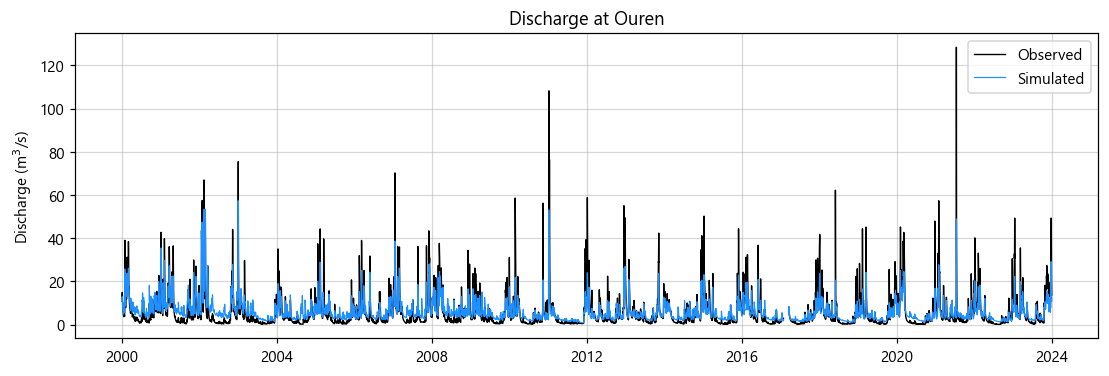

In [15]:
station = 'Ouren'
observed_data_dict = all_eval_stations_Q
simulated_Q_dir = 'extracted_timeseries/Qrouted'

mQ.plot_station_timeseries(station,
                          observed_data_dict,
                          simulated_Q_dir)


In [16]:
model_metrics_val['Ouren']

{'NSE': 0.69, 'KGE': 0.49, 'PBIAS': -10.31, 'LNSE': 0.54}

#### Convert model performance dictionaries to dataframes

In [17]:
#convert the metrics dictionaries to dataframes

# Filter out None entries before conversion
filtered_cal_metrics = {k: v for k, v in model_metrics_cal.items() if v is not None}
filtered_val_metrics = {k: v for k, v in model_metrics_val.items() if v is not None}

# Convert to DataFrame
cal_metrics_df = mQ.dict_to_df(filtered_cal_metrics)
val_metrics_df = mQ.dict_to_df(filtered_val_metrics)


In [18]:
#find the stas with the largest bias
cal_metrics_df.nsmallest(13, 'PBIAS')

,name,NSE,KGE,PBIAS,LNSE
54,Gistel_Moerdijkvaart,-0.46,-0.70,-100.00,NaN
93,Loppem_Kerkebeek,-0.34,-0.41,-95.67,-0.97
113,Mendonk_Moervaart,-1.42,-0.39,-95.30,-28.25
136,Ransberg_Velpe,-0.76,-0.35,-93.53,-18.46
60,Hamoir,-1.11,-0.31,-90.54,-12.79
67,Heule_Heulebeek,-0.38,-0.30,-88.30,-2.41
154,Sint-Michiels_Kerkebeek,-0.12,-0.31,-83.48,0.24
82,Keiem_Ijzer,-0.16,-0.19,-76.62,NaN
51,Geel_Grote Nete,-3.89,-0.15,-76.47,-17.30
172,TINTIGNY,0.18,0.03,-62.04,0.39


#### Map the NSE, LNSE and KGE values

In [19]:
#First convert the metrics to a geodataframe
meta = all_eval_stations.copy()

# Merge on station name
meta = meta.merge(val_metrics_df, on='name', how='left')

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta.lon, meta.lat), crs='EPSG:4326')

#export to shapefile
gdf.to_file('mHM_eval_stations.shp', driver='ESRI Shapefile')

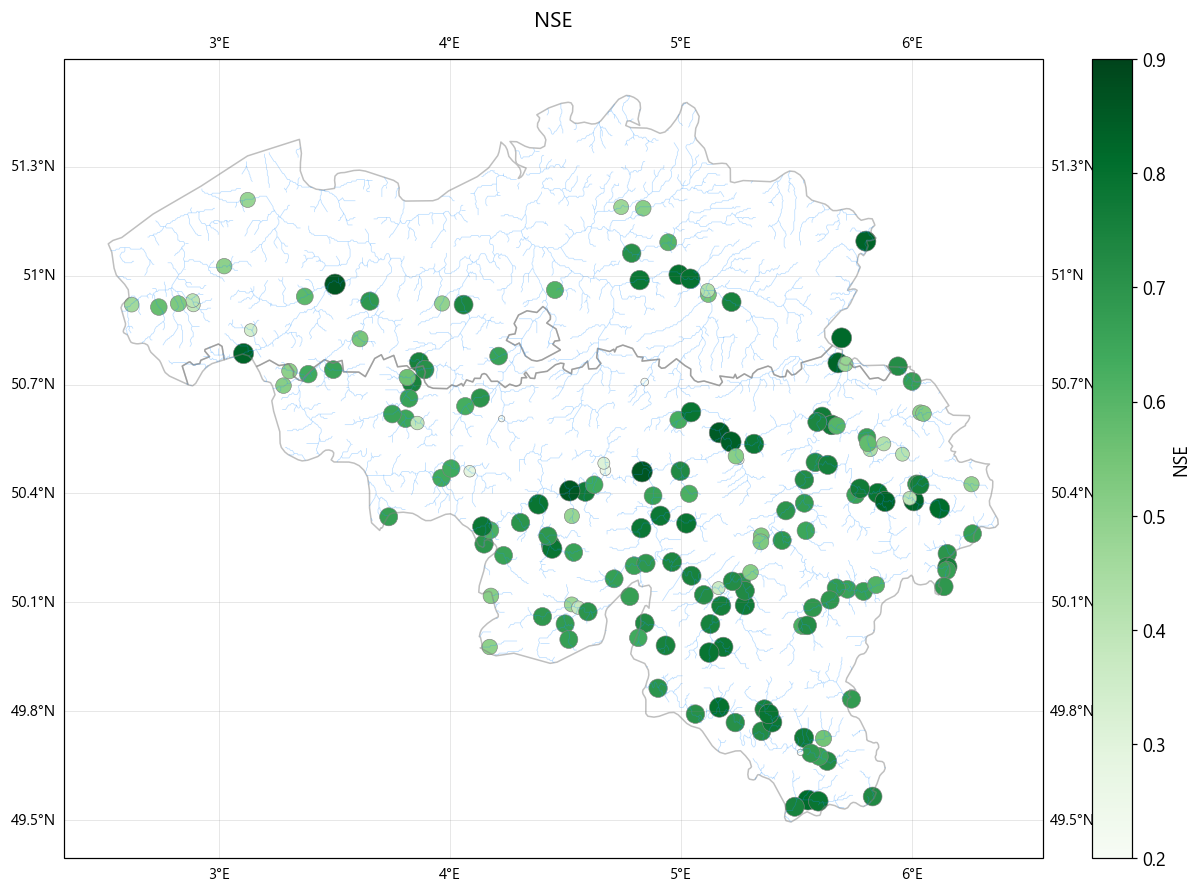

In [20]:
# Shapefile of study area
be_shp = "W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp"
# Shapefile of rivers
rivers_shp_path = "W:/VUB/_main_research/data/shapefiles/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu_shp/hydroRivers_BE.shp"
stats_gdf = gdf.copy()
performance_statistic = 'NSE'
cmap = 'Greens'

# Call the function to plot
mQ.map_model_stats(be_shp, rivers_shp_path,stats_gdf, performance_statistic, cmap)